# Tarea 6: Generando caras con GANs
## Martiñón Luna Joanthan José
### Licenciatura en Ciencia de Datos
### Semestre 2021 - II

Basado en los archivos de:
-  clase
- [Kaggle](https://www.kaggle.com/umutcanakdag/generating-unattractive-female-faces-with-dcgan)

#Hablando de las modificaciones:

En la arquitectura, se agregaron 2 capas más convolucionales 2d (256,(5,5)), para posteriormente tener 2 de (128,(5,5)). Teniendo en cuenta que el dropout nos ayuda a 'desconectar' neuronas y de esa forma, evitar que la red memorize, sino generalice, se agregaron también 2 dropouts en las 2 convolucionales añadidas de 256 con un dropout de (0.2, 0.3) y finalmente, en la última convolucional2D 128, se añadió un dropout de (0.4) 

# Librerías

In [1]:
import pandas as pd
import seaborn as sns
import os
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.image as img
import time
from tensorflow.keras import layers
import tensorflow as tf

# Funciones

In [2]:
def plotea_distribucion(data, x, color="purple", aspecto=2, bins=[10,20,30,40,50]):

    sns.displot(data= data, x=x , color=color, aspect=aspecto,
               bins=bins)

    plt.title(f"Distribución de {x}.\nMedia = {round(np.mean(data[x]),4)}\
    Mín: {np.min(data[x])} Max: {np.max(data[x])}")
    plt.tight_layout()
    plt.show()

# Importando los datos

Instalamos kaggle para hacer uso de la API

In [3]:
! pip install -q kaggle

Aprovechamos el entorno de Google para subir nuestro json con datos

In [4]:
from google.colab import files

In [5]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jhonnyml","key":"ec4acea233f21cef9b7c764ac6e070d4"}'}

Creamos el directorio donde se almacenarán los datos

In [6]:
 ! mkdir ~/.kaggle

Movemos nuestro JSON a la carpeta de KAGGLE

In [7]:
! cp kaggle.json ~/.kaggle/

Ajustamos permisos

In [8]:
!chmod 600 ~/.kaggle/kaggle.json

Descargamos el conjunto de datos que deseamos

In [9]:
! kaggle datasets download -d  jessicali9530/celeba-dataset

 99% 1.32G/1.33G [00:10<00:00, 144MB/s]
100% 1.33G/1.33G [00:10<00:00, 138MB/s]


Descomprimimos nuestro ZIP

In [10]:
!unzip -q celeba-dataset.zip

Eliminamos el ZIP

In [11]:
!rm celeba-dataset.zip

# Análisis

## Lectura de Csv

In [12]:
#!rm -r img_align_celeba/

In [13]:
archivos = os.listdir("./")
archivos

['.config',
 'list_eval_partition.csv',
 'img_align_celeba',
 'kaggle.json',
 'list_bbox_celeba.csv',
 'list_landmarks_align_celeba.csv',
 'list_attr_celeba.csv',
 'sample_data']

In [14]:
landmarks_df = pd.read_csv("./list_landmarks_align_celeba.csv")
bbox_df = pd.read_csv("./list_bbox_celeba.csv")
eval_p = pd.read_csv("./list_eval_partition.csv")
attr_cel = pd.read_csv("./list_attr_celeba.csv")

In [15]:
landmarks_df.head()

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,000001.jpg,69,109,106,113,77,142,73,152,108,154
1,000002.jpg,69,110,107,112,81,135,70,151,108,153
2,000003.jpg,76,112,104,106,108,128,74,156,98,158
3,000004.jpg,72,113,108,108,101,138,71,155,101,151
4,000005.jpg,66,114,112,112,86,119,71,147,104,150


In [16]:
landmarks_df[landmarks_df.columns[1:]].describe()

,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
count,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000
mean,69.353867,111.197982,107.644031,111.161600,88.063140,135.102024,71.247459,152.113011,105.586429,152.194660
std,1.717952,1.129284,1.690252,1.169229,6.647733,4.245078,3.168011,1.799343,3.233125,1.752368
min,56.000000,98.000000,90.000000,95.000000,57.000000,93.000000,57.000000,116.000000,82.000000,114.000000
25%,68.000000,111.000000,107.000000,111.000000,84.000000,133.000000,69.000000,151.000000,103.000000,151.000000
50%,69.000000,111.000000,108.000000,111.000000,88.000000,135.000000,72.000000,152.000000,105.000000,152.000000
75%,70.000000,112.000000,109.000000,112.000000,92.000000,138.000000,73.000000,153.000000,108.000000,153.000000
max,88.000000,129.000000,124.000000,122.000000,121.000000,156.000000,90.000000,174.000000,120.000000,173.000000


In [17]:
bbox_df.head()

,image_id,x_1,y_1,width,height
0,000001.jpg,95,71,226,313
1,000002.jpg,72,94,221,306
2,000003.jpg,216,59,91,126
3,000004.jpg,622,257,564,781
4,000005.jpg,236,109,120,166


In [18]:
bbox_df[bbox_df.columns[1:]].describe()

,x_1,y_1,width,height
count,202599.000000,202599.000000,202599.000000,202599.000000
mean,156.764564,84.335505,194.754061,268.922329
std,164.518135,76.067284,141.770066,195.664936
min,1.000000,0.000000,0.000000,0.000000
25%,69.000000,44.000000,120.000000,166.000000
50%,110.000000,68.000000,164.000000,227.000000
75%,181.000000,98.000000,221.000000,306.000000
max,3840.000000,1858.000000,3827.000000,5299.000000


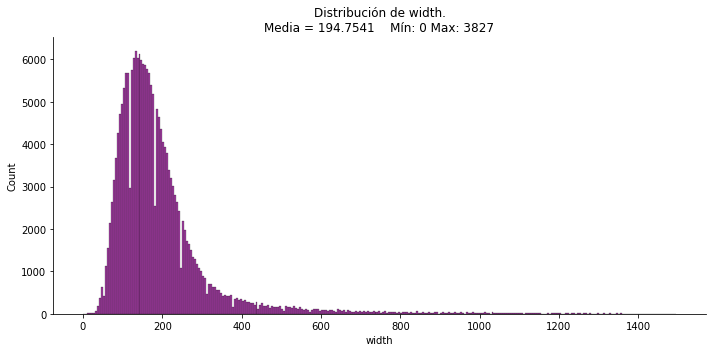

In [19]:
plotea_distribucion(bbox_df, "width", bins=np.arange(0,1500,5))

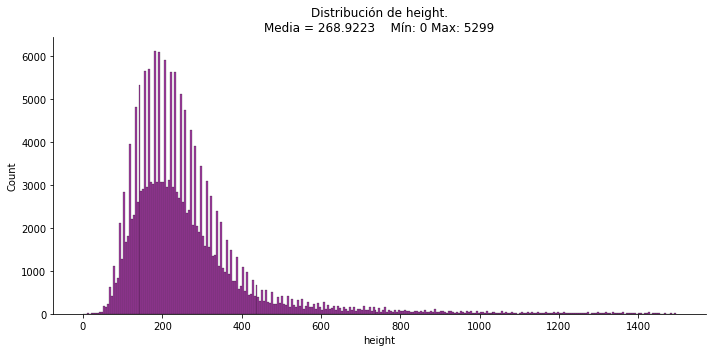

In [20]:
plotea_distribucion(bbox_df, "height", bins=np.arange(0,1500,5))

In [21]:
eval_p.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [22]:
eval_p["partition"].describe()

count    202599.000000
mean          0.295120
std           0.636463
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           2.000000
Name: partition, dtype: float64

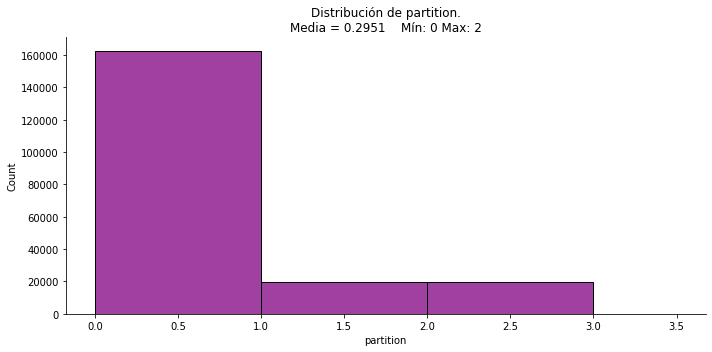

In [23]:
plotea_distribucion(eval_p, "partition", bins=[0,1,2,3,3.5])

In [24]:
attr_cel.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,1,-1,1,-1,-1,1,-1,-1,1,-1,-1,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,-1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [25]:
attr_cel[attr_cel.columns[1:]].describe()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
count,202599.000000,202599.000000,202599.00000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.00000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.00000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000
mean,-0.777728,-0.466039,0.02501,-0.590857,-0.955113,-0.696849,-0.518408,-0.530935,-0.521498,-0.704016,-0.898203,-0.589613,-0.715665,-0.884866,-0.906623,-0.869762,-0.874471,-0.91610,-0.226156,-0.089936,-0.166491,-0.033144,-0.916910,-0.769703,0.669880,-0.431715,-0.914106,-0.445111,-0.840443,-0.868558,-0.886979,-0.035839,-0.583196,-0.360866,-0.62215,-0.903079,-0.055129,-0.754066,-0.854570,0.547234
std,0.628602,0.884766,0.99969,0.806778,0.296241,0.717219,0.855135,0.847414,0.853255,0.710186,0.439582,0.807688,0.698445,0.465846,0.421942,0.493472,0.485079,0.40095,0.974093,0.995950,0.986045,0.999453,0.399096,0.638404,0.742471,0.902012,0.405476,0.895478,0.541901,0.495589,0.461811,0.999360,0.812333,0.932620,0.78290,0.429475,0.998482,0.656800,0.519338,0.836982
min,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000
50%,-1.000000,-1.000000,1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000
75%,-1.000000,1.000000,1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,1.000000,1.000000,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,1.000000,-1.00000,-1.000000,1.000000,-1.000000,-1.000000,1.000000
max,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


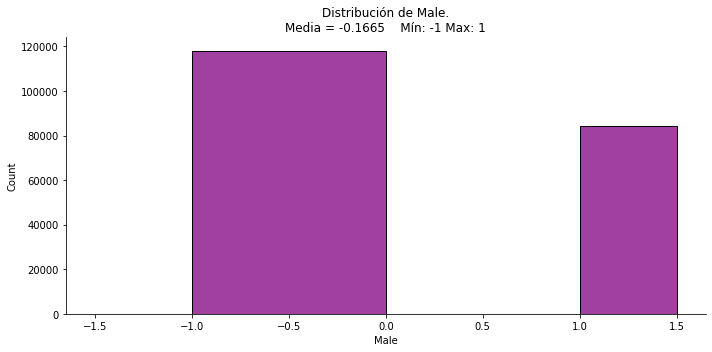

In [26]:
plotea_distribucion(attr_cel, "Male", bins=[-1.5,-1,0,1,1.5])

## Mostramos algunas de las imágenes a trabajar
Como podemos apreciar, no sólo existen mujeres, sino también hombres.

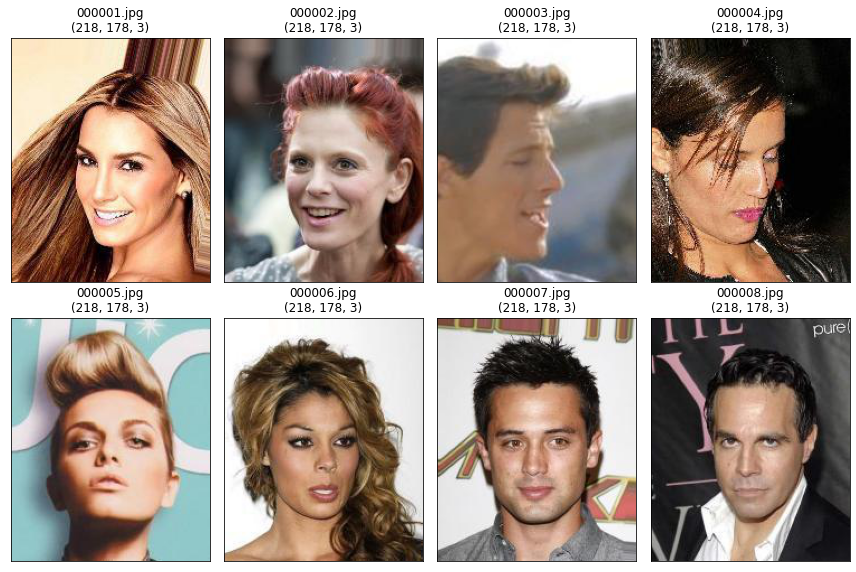

In [27]:
fig, ax = plt.subplots(figsize=(12,8))

for i in range(8):
    
    imagen = img.imread(f"./img_align_celeba/img_align_celeba/00000{i+1}.jpg")
    plt.subplot(2,4,i+1)
    plt.imshow(imagen)
    plt.title(f"00000{i+1}.jpg\n{imagen.shape}")
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()

plt.show()

# Definimos algunas constantes

In [28]:
# tamaño de nuestro Batch
BATCH_SIZE = 256
# Número de épocas
EPOCHS = 200
# Dimensión del ruido
noise_dim = 100
# Ejemplos a generar
num_examples_to_generate = 16
# Ajustamos la semilla (Imagen base)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Generamos los conjuntos de entrenamiento

In [29]:
@tf.function
def preprocessing(img_path):
    # Establecemos la ruta
    img_path = "./img_align_celeba/img_align_celeba/" + img_path
    # Leemos la imagen
    img = tf.io.read_file(img_path)
    # Decodificamos la imagen con 3 canales
    img = tf.image.decode_jpeg(img, channels=3)
    # Ajustamos el tamaño de la imagen
    img = tf.image.resize(img, [28, 28])
    # Reasigamos a valores entre 0 y 1
    img = tf.cast(img, tf.float32) / 255.0
    
    # Devolvemos la imagen preprocesada
    return img

@tf.function
def create_dataset(df, batch_size):
    # Cargamos nuestro dataset en formato de Tensorflow
    ds = tf.data.Dataset.from_tensor_slices((df))
    # Preprocesamos cada audio (Valor del dataset)
    ds = ds.map(preprocessing, tf.data.experimental.AUTOTUNE)
    
    train_dataset = ds.cache().batch(batch_size)
    train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    # Devolvemos nuestro conjunto de entrenamiento
    return train_dataset

In [30]:
# Generamos nuestro conjunto de entrenamiento
train_dataset = create_dataset(attr_cel["image_id"], BATCH_SIZE)

# Diseño del modelo
## Deep Convolutional Generative Adversarial Networks

In [31]:
def make_generator_model():

    # Ajustamos para hacer uso de GPU
    #with tf.device('/device:GPU:0'):
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((7,7,256)))
    # Se agregaron 2 capas de 256 y dropouts
    model.add(layers.Conv2DTranspose(256,(5,5), strides=(1,1), 
                                    padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(.2))

    model.add(layers.Conv2DTranspose(256,(5,5), strides=(1,1), 
                                    padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(.3))

    model.add(layers.Conv2DTranspose(128,(5,5), strides=(1,1), 
                                    padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Agregamos otra capa de 128
    model.add(layers.Conv2DTranspose(128,(5,5), strides=(1,1), 
                                    padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(.4))
    
    model.add(layers.Conv2DTranspose(64,(5,5), strides=(2,2), 
                                    padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Para trabajar con mágenes a color, se modificó esta línea para obtener 3 
    # canales de salida
    model.add(layers.Conv2DTranspose(3,(5,5), strides=(2,2), 
                                      padding="same", use_bias=False,
                                      activation="tanh"))
    
    return model

In [32]:
def make_discriminator_model():

  # Ajustamos para hacer uso de GPU
    #with tf.device('/device:GPU:0'):

    model = tf.keras.Sequential()
    # Ajustamos el tamaño de la entrada para que sirva con 3 canales
    model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding="same", 
                          input_shape=[28,28,3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model

Probamos nuestro generador Podemos observar que el tamaño de salida resulta en 28 x 28 x 3 canales

In [33]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 256)         1638400   
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 256)         1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 256)         0

Probamos ejecutar un ruido y observar el comportamiento

In [34]:
# Generamos ruido normal
noise = tf.random.normal([100, 100])
# Generamos la imagen a partir del ruido
generated_image = generator(noise, training=False)
# Mostramos la cantidad de imágenes generadas a partir del ruido
print(f"Se generaron {generated_image.shape[0]} imagenes")

Se generaron 100 imagenes


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


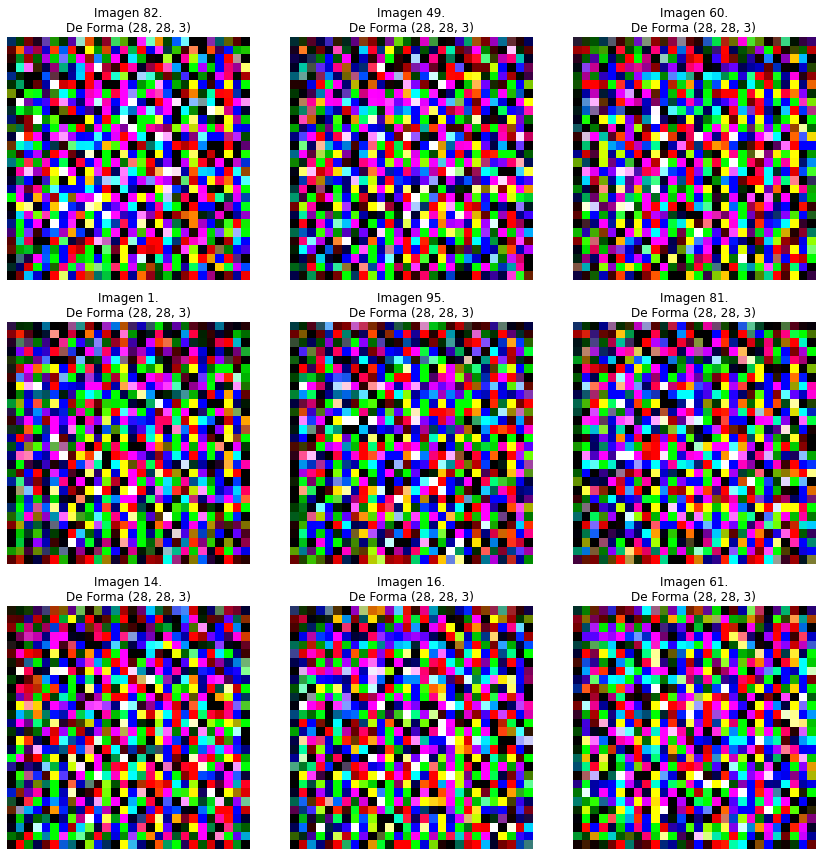

In [35]:
# Mostramos algunas imágenes generadas apartir de ruido
plt.figure(figsize=(12,12))

for i in range(9):
        plt.subplot(3,3,i+1)
        aux = np.random.randint(0,100)
        plt.title(f"Imagen {aux+1}.\nDe Forma {generated_image[aux].shape}")
        plt.imshow(generated_image[aux]*255)
        plt.axis("off")
plt.tight_layout()
plt.show()

In [36]:
# Probamos nuestro discriminador
discriminator = make_discriminator_model()
# Mostraremos sólo para los primeros 10
resultados = discriminator(generated_image)[:10] 
# si el valor es negativo es falsa 
for i,resultado in enumerate(resultados):
    if resultado <0:
        print(i,"Falso: ",resultado)
    else:
        print(i,"Verdadero: ",resultado)

0 Verdadero:  tf.Tensor([0.0005918], shape=(1,), dtype=float32)
1 Verdadero:  tf.Tensor([0.00074825], shape=(1,), dtype=float32)
2 Verdadero:  tf.Tensor([0.00060686], shape=(1,), dtype=float32)
3 Verdadero:  tf.Tensor([0.00089958], shape=(1,), dtype=float32)
4 Verdadero:  tf.Tensor([0.0004028], shape=(1,), dtype=float32)
5 Verdadero:  tf.Tensor([0.00115123], shape=(1,), dtype=float32)
6 Verdadero:  tf.Tensor([0.00161961], shape=(1,), dtype=float32)
7 Verdadero:  tf.Tensor([0.00130065], shape=(1,), dtype=float32)
8 Verdadero:  tf.Tensor([0.00041136], shape=(1,), dtype=float32)
9 Verdadero:  tf.Tensor([0.00108027], shape=(1,), dtype=float32)


In [37]:
# Definimos nuestra funciónd de pérdida
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [38]:
# Pérdida del discriminador
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [39]:
# Pérdida del generador
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [40]:
# Optimizadores
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [41]:
checkpoint_dir = "./training_checkpoints"
checkpoing_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimzer = discriminator_optimizer,
                                generator=generator,
                                discriminator=discriminator)

In [42]:
@tf.function
def train_step(images):

    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, \
         tf.GradientTape() as disc_tape,\
         tf.device('/device:GPU:0'):

        generated_images = generator(noise,training=True)
        
        
        real_output = discriminator(images,training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [43]:
def generate_and_save_image(model,epoch,test_input):
    
    predictions = model(test_input, training=False)
    
    fig = plt.figure(figsize=(4,4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow(predictions[i,:,:0] * 127.5 + 127.5, cmap="gray")
        plt.axis("off")
        
    plt.savefig("image_at_epoch{:04d}.png", format(epoch))
    plt.show()

In [44]:
def display_images():
    
    predictions = generator(seed, training=False)
    
    plt.figure()
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i]* 255).numpy().astype(np.uint8))
        plt.axis('off')
    plt.show()

In [45]:
def train(dataset,epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for image_batch in dataset:
            train_step(image_batch)

        print("Time for epoch {} is {} s".format(epoch+1, time.time()- start))
        # En teoría sólo se deben mostrar 4 fases
        if (epoch+1) % 50 == 0:
            display_images()

# Entrenando el modelo

Time for epoch 1 is 98.0353798866272 s
Time for epoch 2 is 82.65220618247986 s
Time for epoch 3 is 82.84740042686462 s
Time for epoch 4 is 82.53085613250732 s
Time for epoch 5 is 82.7547836303711 s
Time for epoch 6 is 82.44726705551147 s
Time for epoch 7 is 82.66236782073975 s
Time for epoch 8 is 82.78518557548523 s
Time for epoch 9 is 82.9400782585144 s
Time for epoch 10 is 82.7438383102417 s
Time for epoch 11 is 82.54668617248535 s
Time for epoch 12 is 82.49268817901611 s
Time for epoch 13 is 82.72861552238464 s
Time for epoch 14 is 82.65341424942017 s
Time for epoch 15 is 82.72061848640442 s
Time for epoch 16 is 82.78494381904602 s
Time for epoch 17 is 82.80615901947021 s
Time for epoch 18 is 82.70553040504456 s
Time for epoch 19 is 82.5002589225769 s
Time for epoch 20 is 82.4192943572998 s
Time for epoch 21 is 82.80255126953125 s
Time for epoch 22 is 82.85472059249878 s
Time for epoch 23 is 82.74183177947998 s
Time for epoch 24 is 82.60640668869019 s
Time for epoch 25 is 82.4756610

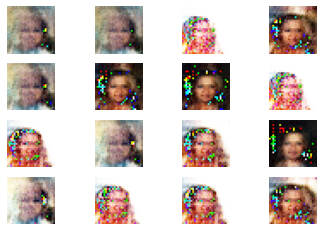

Time for epoch 51 is 82.65340256690979 s
Time for epoch 52 is 82.57201337814331 s
Time for epoch 53 is 82.24596524238586 s
Time for epoch 54 is 82.41042876243591 s
Time for epoch 55 is 82.71619915962219 s
Time for epoch 56 is 82.84579634666443 s
Time for epoch 57 is 82.72966742515564 s
Time for epoch 58 is 82.59360671043396 s
Time for epoch 59 is 82.42741990089417 s
Time for epoch 60 is 82.4949197769165 s
Time for epoch 61 is 82.81313228607178 s
Time for epoch 62 is 82.45063900947571 s
Time for epoch 63 is 82.42028093338013 s
Time for epoch 64 is 82.42343997955322 s
Time for epoch 65 is 82.27854871749878 s
Time for epoch 66 is 82.66000819206238 s
Time for epoch 67 is 82.58731818199158 s
Time for epoch 68 is 82.77673530578613 s
Time for epoch 69 is 82.70193028450012 s
Time for epoch 70 is 82.68364024162292 s
Time for epoch 71 is 82.67122960090637 s
Time for epoch 72 is 82.68267965316772 s
Time for epoch 73 is 82.69867038726807 s
Time for epoch 74 is 141.92032837867737 s
Time for epoch 7

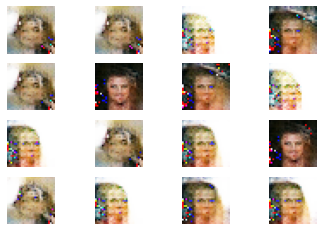

Time for epoch 101 is 82.59832549095154 s
Time for epoch 102 is 82.46636629104614 s
Time for epoch 103 is 82.85469675064087 s
Time for epoch 104 is 82.46771359443665 s
Time for epoch 105 is 82.8740565776825 s
Time for epoch 106 is 82.70108771324158 s
Time for epoch 107 is 82.48652148246765 s
Time for epoch 108 is 82.54589891433716 s
Time for epoch 109 is 82.53938674926758 s
Time for epoch 110 is 82.4596176147461 s
Time for epoch 111 is 82.66091656684875 s
Time for epoch 112 is 82.86117506027222 s
Time for epoch 113 is 82.67581033706665 s
Time for epoch 114 is 82.51658129692078 s
Time for epoch 115 is 82.45317101478577 s
Time for epoch 116 is 82.64295053482056 s
Time for epoch 117 is 82.76225209236145 s
Time for epoch 118 is 82.79495573043823 s
Time for epoch 119 is 82.67520403862 s
Time for epoch 120 is 82.63634276390076 s
Time for epoch 121 is 82.56694054603577 s
Time for epoch 122 is 82.59675478935242 s
Time for epoch 123 is 82.56151413917542 s
Time for epoch 124 is 82.89737200737 s


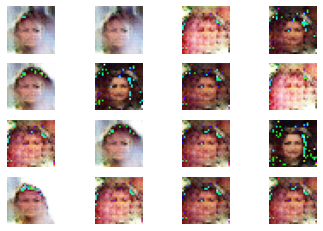

Time for epoch 151 is 82.55412459373474 s
Time for epoch 152 is 82.84820771217346 s
Time for epoch 153 is 82.90723848342896 s
Time for epoch 154 is 82.42290449142456 s
Time for epoch 155 is 82.36709880828857 s
Time for epoch 156 is 82.35581421852112 s
Time for epoch 157 is 82.58673143386841 s
Time for epoch 158 is 82.65249872207642 s
Time for epoch 159 is 82.6947329044342 s
Time for epoch 160 is 82.65452289581299 s
Time for epoch 161 is 82.6229956150055 s
Time for epoch 162 is 82.70951867103577 s
Time for epoch 163 is 82.85897326469421 s
Time for epoch 164 is 82.85662341117859 s
Time for epoch 165 is 82.63254714012146 s
Time for epoch 166 is 82.72595381736755 s
Time for epoch 167 is 82.92331671714783 s
Time for epoch 168 is 82.9829363822937 s
Time for epoch 169 is 82.4847583770752 s


In [ ]:
train(train_dataset,EPOCHS)

# Testeando el modelo

### A partir de nuestras imágenes, generaremos una imagen sólo que difuminada

Desgraciadamente, por la limitación de COLAB, y la falta de recursos computacionales de manera local, el entrenamiento no logró llevarse a cabo en su totalidad. Tal cual se puede apreciar en la parte superior, hemos llegado a entrenar 169 épocas. Desgraciadamente, en este punto, colab ha detenido el proceso por motivos de uso de GPU.

Cabe destacar que intenté correrlo de manera local. Tardó Media hora en entrenar 1 sóla época usando mis núcleos (4) al 90%. Si pensamos en el mismo tiempo  (2 épocas por hora aprox.) para las 200 épocas, necesitaría un total de 100 horas, equivalente a 4 días con 4 horas (Que excede el tiempo de entrega)

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
import random
 
# Listamos las imágenes
imgs = os.listdir("./img_align_celeba/img_align_celeba/")
# Seleccionamos una imagen aleatoria
img = cv2.imread('./img_align_celeba/img_align_celeba/'+random.choice(imgs))
# aplicamos un filtro de 5 x 5
blur = cv2.blur(img,(5,5))
 
# mostramos la imagen
plt.subplot(121),plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(blur),plt.title('Difuminada')
plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
predictions = generator(blur, training=False)

In [ ]:
fig = plt.figure(figsize=(4,4))
    
for i in range(predictions.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(predictions[i,:,:0] * 127.5 + 127.5, cmap="gray")
    plt.axis("off")
    
plt.savefig("image_at_epoch{:04d}.png", format(epoch))
plt.show()